In [1]:
from exp.nb_Tesis import *

In [38]:
min_dim = 64 # 448

trainImagesFolderName = f'small_{min_dim}_ISIC_2019_Training_Input'
trainingGroundTruthFileName = 'ISIC_2019_Training_GroundTruth.csv'
testImagesFolderName = 'ISIC2018_Task3_Test_Input'
smallTestImagesFolderName = f'small_{min_dim}_ISIC2018_Task3_Test_Input'

trainingGroundTruthFileName = 'ISIC_2019_Training_GroundTruth.csv'


In [39]:
df = pd.read_csv(trainingGroundTruthFileName); print('# of images: ', len(df)); df.head()

# of images:  25331


,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
dfSingleLabel = pd.DataFrame({'image':df['image'] })
labelcols = df.columns[1:len(df.columns)]
dfSingleLabel['label'] = df[list(labelcols)].idxmax(axis='columns')
dfSingleLabel.head()

,image,label
0,ISIC_0000000,NV
1,ISIC_0000001,NV
2,ISIC_0000002,MEL
3,ISIC_0000003,NV
4,ISIC_0000004,MEL


In [41]:
labels_for_2018_live_challenge = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC']

def get_label_for_image_name(image_name):
  return list(dfSingleLabel.loc[dfSingleLabel['image']==image_name].label)[0]
  
def get_label_for_image_path(image_path): return get_label_for_image_name(image_path.name[:-4])

In [42]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [43]:
random_seed(42,True)
tfms = get_transforms(flip_vert=True, max_rotate=180,max_zoom=1.3, max_lighting=.3,p_affine=1, max_warp=0)

data = ImageList.from_folder(trainImagesFolderName)\
.split_by_rand_pct()\
.label_from_func(get_label_for_image_path)\
.transform(tfms,size=128)\
.databunch(bs=64)\
.normalize()

In [24]:
data.train_ds

LabelList (20265 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
MEL,NV,NV,NV,MEL
Path: small_128_ISIC_2019_Training_Input

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe6bce1e170>
Traceback (most recent call last):
  File "/home/mike/miniconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/mike/miniconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/home/mike/miniconda3/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/home/mike/miniconda3/lib/python3.7/multiprocessing/popen_fork.py", line 48, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/home/mike/miniconda3/lib/python3.7/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


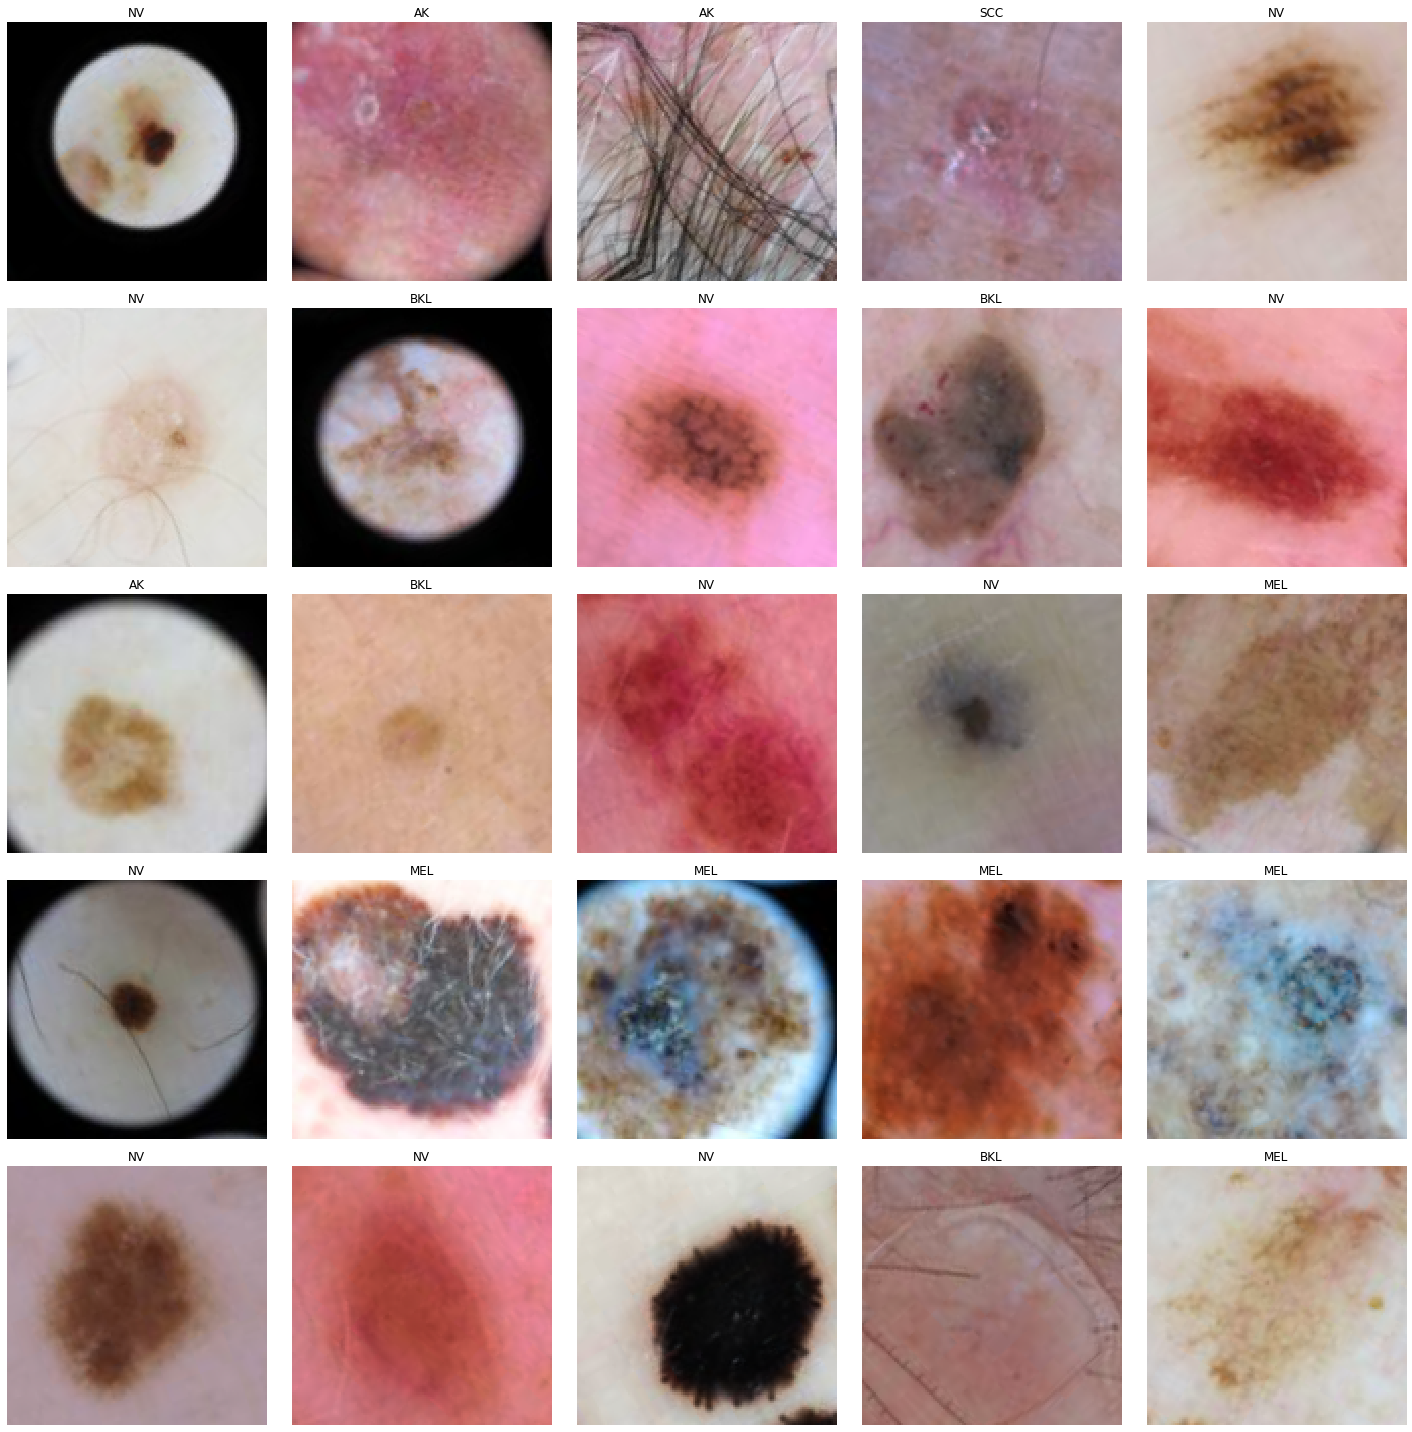

In [17]:
data.show_batch(6)

In [44]:
train_count,valid_count = pd.value_counts(data.train_ds.y.items),pd.value_counts(data.valid_ds.y.items)
train_count.index,valid_count.index = [data.classes[i] for i in train_count.index],[data.classes[i] for i in valid_count.index]

print('train_count: \n',train_count,'\n\n','valid_count: \n', valid_count)
print('ratios:')
print(valid_count / train_count, '%')

train_count: 
 NV      10361
MEL      3579
BCC      2670
BKL      2065
AK        692
SCC       510
VASC      203
DF        185
dtype: int64 

 valid_count: 
 NV      2514
MEL      943
BCC      653
BKL      559
AK       175
SCC      118
DF        54
VASC      50
dtype: int64
ratios:
AK      0.252890
BCC     0.244569
BKL     0.270702
DF      0.291892
MEL     0.263481
NV      0.242641
SCC     0.231373
VASC    0.246305
dtype: float64 %


In [33]:
from efficientnet_pytorch import EfficientNet

model_name = 'efficientnet-b0'
model = EfficientNet.from_pretrained(model_name)
model._fc = nn.Linear(1280, data.c) # si es b0 poner aca 1280, si es b3 poner 1536

x50 = lambda x: xresnet50()
learn = Learner(data,model, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[
                            ShowGraph,
                            ActivationStats,
                                  ]               )

learn.summary()

Loaded pretrained weights for efficientnet-b0


EfficientNet
Layer (type)         Output Shape         Param #    Trainable 
ZeroPad2d            [3, 129, 129]        0          False     
______________________________________________________________________
BatchNorm2d          [32, 64, 64]         64         True      
______________________________________________________________________
ZeroPad2d            [32, 66, 66]         0          False     
______________________________________________________________________
BatchNorm2d          [32, 64, 64]         64         True      
______________________________________________________________________
Identity             [32, 1, 1]           0          False     
______________________________________________________________________
Identity             [8, 1, 1]            0          False     
______________________________________________________________________
Identity             [32, 64, 64]         0          False     
_________________________________________________

In [34]:
weighted_classes = [{c: max(train_count) / train_count[c]} for c in data.classes];
print(weighted_classes)
formatted_weights = [w[c] for c,w in zip(data.classes, weighted_classes) ] 
print(formatted_weights)

class_weights=torch.FloatTensor(formatted_weights).cuda()
learn.loss_func = CrossEntropyFlat(weight = class_weights)

[{'AK': 14.972543352601155}, {'BCC': 3.8805243445692885}, {'BKL': 5.017433414043584}, {'DF': 56.005405405405405}, {'MEL': 2.894942721430567}, {'NV': 1.0}, {'SCC': 20.315686274509805}, {'VASC': 51.039408866995075}]
[14.972543352601155, 3.8805243445692885, 5.017433414043584, 56.005405405405405, 2.894942721430567, 1.0, 20.315686274509805, 51.039408866995075]


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.482123,1.420225,0.376826,0.623174,0.534341,00:54
1,1.413899,1.431359,0.417884,0.582116,0.739882,00:55
2,1.312851,1.531843,0.541058,0.458942,0.687369,00:54
3,1.197963,1.225407,0.404856,0.595144,0.742289,00:54
4,1.052125,1.149919,0.427359,0.572641,0.514378,00:54
5,0.927384,0.973394,0.369917,0.630083,0.465896,00:54
6,0.783662,0.894377,0.325109,0.674891,0.479623,00:53
7,0.728870,0.878097,0.331820,0.668180,0.494772,00:53


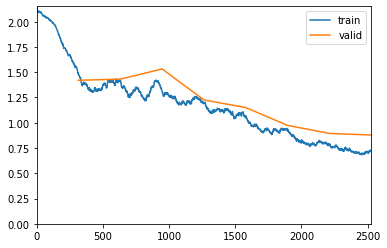

Better model found at epoch 0 with valid_loss value: 1.4202251434326172.
Better model found at epoch 3 with valid_loss value: 1.2254070043563843.
Better model found at epoch 4 with valid_loss value: 1.149919033050537.
Better model found at epoch 5 with valid_loss value: 0.9733937978744507.
Better model found at epoch 6 with valid_loss value: 0.8943770527839661.
Better model found at epoch 7 with valid_loss value: 0.8780969381332397.


In [35]:
random_seed(7,True)

max_lr = slice(1e-3,1e-2)
wd = 1e-4
learn.fit_one_cycle(8,max_lr=1e-3,wd=wd, callbacks = [
    SaveModelCallback(learn=learn,name=f'2019_imgsz_{min_dim}_{model_name}'),
    CSVLogger(learn=learn,filename=model_name)
#     ReduceLROnPlateauCallback(learn=learn)
])

In [36]:
learn.save('stage-1')

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.691749,0.887557,0.328859,0.671141,0.464859,00:55
1,0.665408,0.908372,0.333597,0.666403,0.436346,00:54
2,0.599382,0.938961,0.319384,0.680616,0.407002,00:55
3,0.582279,0.969560,0.309712,0.690288,0.435365,00:55
4,0.453909,0.967013,0.315634,0.684366,0.374313,00:54
5,0.461267,0.966449,0.308133,0.691867,0.358331,00:55
6,0.509369,0.942903,0.301421,0.698579,0.388530,00:54
7,0.599082,0.897729,0.307146,0.692854,0.441268,00:53
8,0.591211,0.893935,0.312870,0.687130,0.443594,00:54
9,0.551923,0.895508,0.313265,0.686735,0.447552,00:54


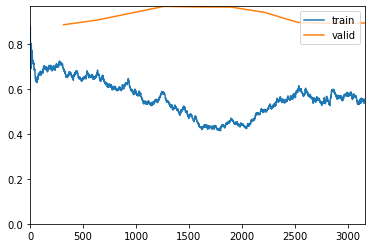

Better model found at epoch 0 with valid_loss value: 0.8875570893287659.


In [37]:
random_seed(7,True)

learn.fit_one_cycle(10, max_lr=1e-4,wd=1e-5, callbacks = [
    SaveModelCallback(learn=learn,name=f'2019_imgsz_{min_dim}_{model_name}'),
    CSVLogger(learn=learn,filename=model_name)
#     ReduceLROnPlateauCallback(learn=learn)
])

In [40]:
learn.load('eff_b0_2019_352')

Learner(data=ImageDataBunch;

Train: LabelList (20265 items)
x: ImageList
Image (3, 352, 352),Image (3, 352, 352),Image (3, 352, 352),Image (3, 352, 352),Image (3, 352, 352)
y: CategoryList
MEL,NV,NV,NV,MEL
Path: small_448_ISIC_2019_Training_Input;

Valid: LabelList (5066 items)
x: ImageList
Image (3, 352, 352),Image (3, 352, 352),Image (3, 352, 352),Image (3, 352, 352),Image (3, 352, 352)
y: CategoryList
NV,NV,MEL,NV,VASC
Path: small_448_ISIC_2019_Training_Input;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 

In [45]:
learn.export('2018_new.pkl')

In [85]:
learn2 = load_learner(path=trainImagesFolderName, file="2018_new.pkl", 
                     test=ImageList.from_folder(smallTestImagesFolderName),
                     )

In [86]:
preds, y = learn2.TTA(ds_type=DatasetType.Test, beta=0.4, scale=1.35)

In [87]:
arrOfPreds = [learn2.data.classes[pred.argmax().item()] for pred in preds];arrOfPreds[0:5]

['MEL', 'MEL', 'MEL', 'VASC', 'AK']

In [88]:

allCategories = learn2.data.classes
cols = ['image'] + allCategories


predictions = []
for idx, filePath in enumerate(learn2.data.test_ds.items):
  row = {}
  current_pred = preds[idx]
  max_confidence = current_pred.max().item()
  row['image'] = filePath.name.replace('.jpg','')
  for idx2, cat in enumerate(allCategories):
    row[cat] = current_pred[idx2].item()
  
  predictions.append(row)

predictionsDf = pd.DataFrame(predictions, columns=cols);
  
  

In [89]:
len(predictionsDf)
predictionsDf = predictionsDf.rename(columns={'AK':'AKIEC'})
predictionsDf2 = predictionsDf.drop(columns=['SCC'])
predictionsDf2.head()

,image,AKIEC,BCC,BKL,DF,MEL,NV,VASC
0,ISIC_0035345,0.020480,0.002645,0.322237,0.004223,0.490462,0.141030,0.000552
1,ISIC_0035958,0.006928,0.002758,0.038562,0.006924,0.593806,0.341068,0.000632
2,ISIC_0035436,0.052250,0.041091,0.116915,0.064746,0.339396,0.079886,0.001101
3,ISIC_0035852,0.000904,0.013041,0.075955,0.006591,0.060583,0.303508,0.538497
4,ISIC_0035330,0.594475,0.112487,0.093799,0.003863,0.021993,0.008791,0.001087


In [90]:
predictions_csv_path = 'predictionsTest2019.csv'
predictionsDf2.to_csv(predictions_csv_path, index=False)